<a href="https://colab.research.google.com/github/dope232/transformers_application-/blob/main/transformers4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Transformer Architecture using [AIAYN paper](https://arxiv.org/abs/1706.03762)



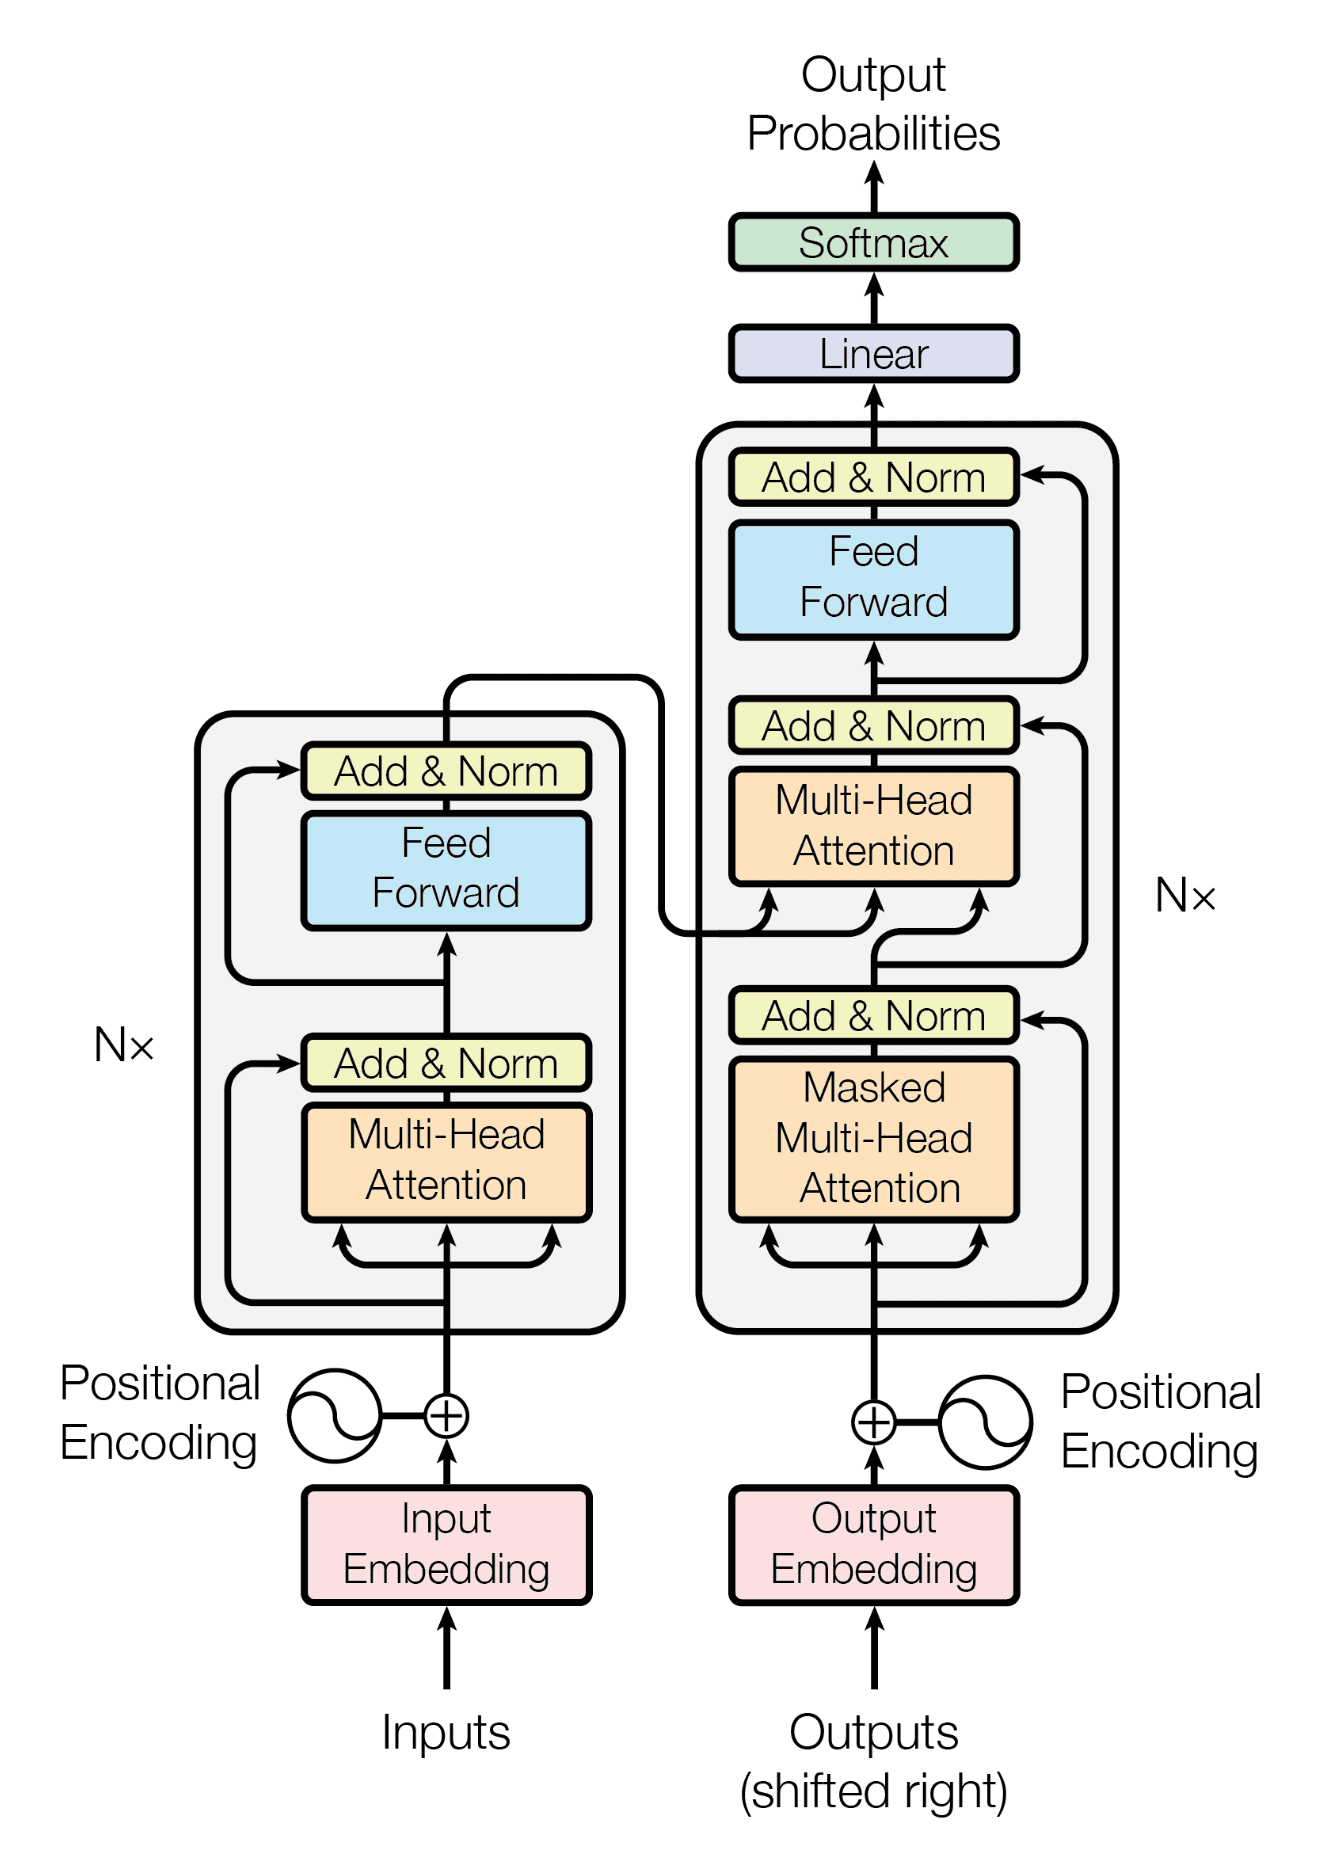

In [ ]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F


In [ ]:

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is not available.



## Basic unit of an attention
- Consists of query,key and value matrices ,
-query and key vector should be similar, thus we multiply them both and softmak to turn into a prob distribuition







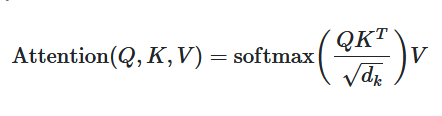

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

## [Positional encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
- location or position of an entity in a sequence
why this function?
Sinusodial, so better periodicity
Uniqueness and boundness - simple indexing won't work because of this


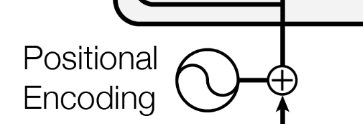

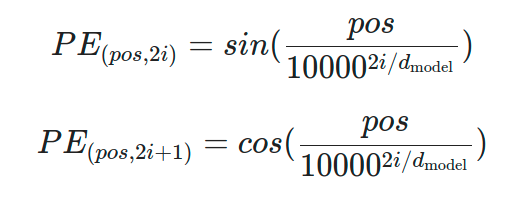

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE


##[Sentence Embedding](https://en.wikipedia.org/wiki/Sentence_embedding)

Takes in accoint of PE as well
Word Embeddings: Each word is converted to a  vector representation.

Positional Encoding: Adds information about the position of each word in the sentence.

-Special Tokens: Handles start, end, and padding tokens to deal with variable-length sentences and to provide sentence boundaries.

-Fixed-length Output: Ensures all sentence embeddings have the same length for batch processing.

-Dropout: Applies regularization to prevent overfitting.

In [ ]:
class SentenceEmbedding(nn.Module):

    def __init__(self, max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token, end_token):

        def tokenize(sentence, start_token, end_token):
            sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
            if start_token:
                sentence_word_indicies.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_indicies.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_indicies), self.max_sequence_length):
                sentence_word_indicies.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_indicies)

        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token, end_token): # sentence
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x

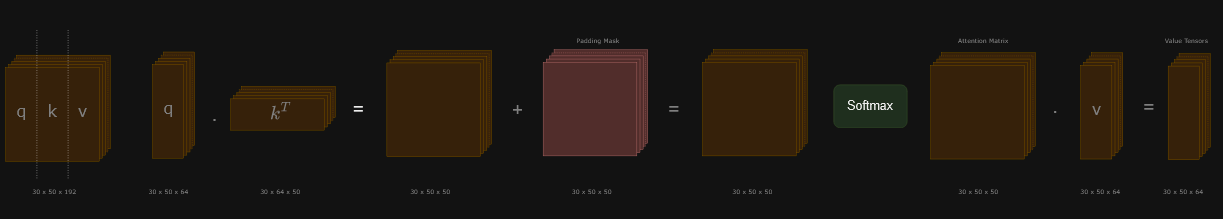

In [ ]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out

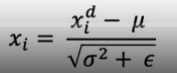



## Layer Normalization

 - adjusts the values within each individual input sample to have a consistent scale, standardizing the neuron activations along the axis of the features
subtract the mean from them. We then divide the value by the standard deviation
-add a small value to the denominator just to make sure that it never ends up being zero, thus blowing up this course to infinity
-

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out



In [ ]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size()
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


## Positionwise- Feed Forward

simple neural network applied to each position in the sequence independently. Here are three key points in simple sentences:

It usually consists of two linear layers with a non-linear activation function(in this case being [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
  in between.
Its purpose is to add depth and complexity to the model, allowing it to learn more complex patterns at each position.


In [ ]:

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


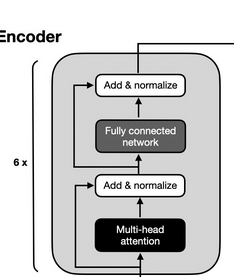

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x

class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x


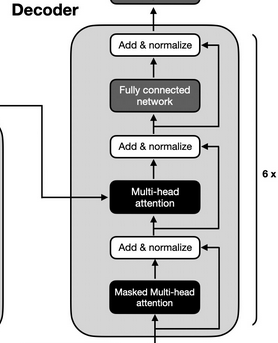

In [ ]:

class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y


class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y


## Encoder Layer

- EncoderLayer processes the input through one cycle of self-attention, feed-forward, and normalization.

- Encoder first embeds the input sentences, then passes them through multiple EncoderLayers.


In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start_token, end_token):
        x = self.sentence_embedding(x, start_token, end_token)
        x = self.layers(x, self_attention_mask)
        return x


In [ ]:

class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start_token, end_token):
        y = self.sentence_embedding(y, start_token, end_token)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y


In [ ]:

class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                kn_vocab_size,
                english_to_index,
                hindi_to_index,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, hindi_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.linear = nn.Linear(d_model, kn_vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,
                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False, # We should make this true
                dec_end_token=False): # x, y are batch of sentences
        x = self.encoder(x, encoder_self_attention_mask, start_token=enc_start_token, end_token=enc_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start_token=dec_start_token, end_token=dec_end_token)
        out = self.linear(out)
        return out

## Dimensional  model

- is the size of every single vector( one word is split into vector of 512 elements.

## No of head

 (Multiheaded attention transformers)→ performing 8 times in parallel


## Dropout

- We're going to be performing something called dropout, where we're going to randomly turn off certain neurons. And what this allows the neural network to do is it forces it to learn along different paths over here, and thus make weight updates accordingly.
- This will help the neural network be better able to generalize data instead of accidentally memorizing specific data. And effectively, this acts as a regularizer, if you've heard the concept of regularization, for neural networks.
- pretty useful when it comes to very deep networks with a lot of connections and parameters.

## Batch Size

- Pass in multiple examples at the same time, this examples constitute a batch;
- Faster training, More stable training


## Max Sequence Length

- Largest no of words, that awe can passing in at a time through the encoder.
- if less words; Lots of padding tokens.
-

## FFN(Feed Foward Network)

- A Feed Forward Network (FFN) is a type of neural network where connections between nodes do not form cycles. Information moves in one direction, from input to output.
- It typically consists of an input layer, one or more hidden layers, and an output layer. Each layer transforms the input data in some way to help the network learn and make predictions.

/

## Num of layers-

No of encoder units we want to make in our transformer encoder

In [ ]:
dmodel = 512
batch_size = 30
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.25
num_layers = 6
max_sequence_length = 250
hin_vocab_size = len(hindi_vocabulary)

